# Heart Disease EDA
## Marco Gancitano
### 1 Feb 2019

<a id=top ></a>
**Table of Contents:**
1. [Variable Overview](#1)
2. [Loading in Data (SKIP TO CODE)](#2)
3. [Variable Insight](#3)
    1. [Categorical Variables](#4)
    1. [Continuous Variables](#5)
    1. [Correlations](#6)
4. [Modeling](#7)
     1. [Logistic Regression](#8)
     1. [Simple Random Forest Classifier](#9)
     1. [Model Fine Tuning](#10)
     1. [Final Model](#11)
5. [Conclusion](#12)
6. [Future Works](#13)

<a id="1"></a>
## Variable Overview
I start with looking at each variable and understanding what it means and the values it can entail.  
I do this to help with domain knowledge and hopefully feature engineering throughout the process. 

1. age: Age in years
2. sex: Sex (1 = Male, 0 = Female)
3. cp: Chest Pain Type (0-4)
    - 0, Typical angina
        - Chest pain related decrease blood supply to the heart
    - 1, Atypical angina
        - Chest pain not related to heart
    - 2, Non-anginal pain
        - Typically esophageal spasms (non heart related)
    - 3, Asymptomatic
        - Chest pain not showing signs of disease
4. trestbps: Resting blood pressure upon admission (mm Hg)
    - Anything above 130-140 is typically cause for concern
5. chol: Serum cholestrol level (mg/dL)
    - serum = LDL + HDL + .2 * triglycerides
    - Above 200 is cause for concern
6. fbs: Fasting blood sugar > 120 mg/dL (1 = True, 0 = False) 
    - fbs > 126 mg/dL signals diabetes
7. restecg: Resting electrocardiographic results (0 - 2)
    - 0, Nothing to note
    - 1, ST-T Wave abnormality
        - Can range from mild symptoms to severe problems
        - Signals non-normal heart beat
    - 2, Possible or definite Left ventricular hypertrophy
        - Enlarged heart's main pumping chamber
8. thalach: Maximum heart rate achieved
    - Rate above 100 is cause for concern
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak: ST depression induced by exercise relative to rest
    - Looks at stress of heart during excercise
    - Unhealthy heart will stress more
11. slope: the slope of the peak exercise ST segment
    - 0, upsloping
       - Better heart rate with excercise (uncommon)
    - 1, flatsloping
        - Minimal change (typical healthy heart)
    - 2, downsloping
        - Signs of unhealthy heart
12. ca: number of major vessels (0-3) colored by flourosopy
    - Colored vessel means the doctor can see the blood passing through
        - Move blood movement the better (no clots)
13. thal: Thalium stress test result
    - Sees how blood moves through your heart while excercising
    - 1, Normal
    - 6, fixed defect
        - Used to be defect but now okay
    - 7, reversable defect
        - Not proper blood movement when excercising
14. target: Heart Disease (1 = True, 0 = False)




NOTES: 
1. Stumbled upon this rule of thumb while researching: Maximum Heart Rate = 220 - Age  
    - Possibly use it as a baseline for the max heart rate achieved?

<hr>
<hr>

<a id="2"></a>
## Import Packages and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('../input/heart.csv')

In [2]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


Pretty even mix between discrete and continuous variables

In [3]:
df.shape

(303, 14)

We see here that we only have 300 observations which is quite low to build robust models so EDA will be the concentration here.

In [4]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Good to see we don't have any NA values

<hr>

<a id="3"></a>
## Variable Insight
We'll look through the categorical variables first and then move on to continuous variables and check out their correlations

<a id="4"></a>
### Categorical Variables

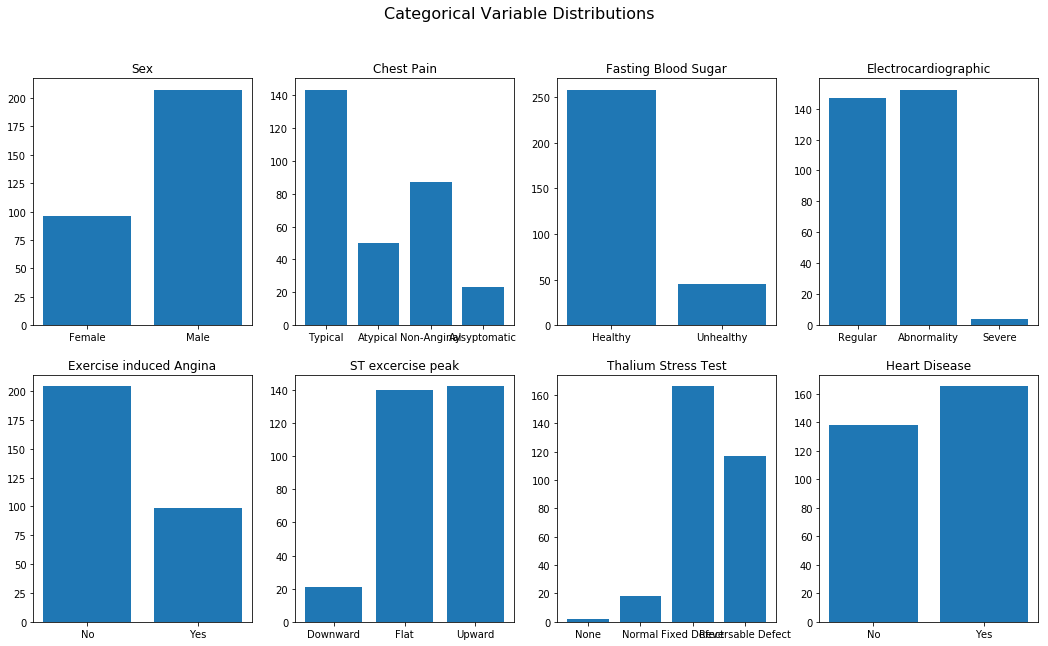

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 10))
fig.suptitle("Categorical Variable Distributions", fontsize=16)

x = ['Female','Male']
y = df.sex.value_counts(sort = False).values
axes[0][0].bar(x,y)
axes[0][0].set_title('Sex')

x = ['Typical','Atypical','Non-Anginal','Aysyptomatic']
y = df.cp.value_counts(sort = False).values
axes[0][1].bar(x,y)
axes[0][1].set_title('Chest Pain')

x = ['Healthy','Unhealthy']
y = df.fbs.value_counts(sort = False).values
axes[0][2].bar(x,y)
axes[0][2].set_title('Fasting Blood Sugar')

x = ['Regular','Abnormality','Severe']
y = df.restecg.value_counts(sort = False).values
axes[0][3].bar(x,y)
axes[0][3].set_title('Electrocardiographic')


x = ['No','Yes']
y = df.exang.value_counts(sort = False).values
axes[1][0].bar(x,y)
axes[1][0].set_title('Exercise induced Angina')

x = ['Downward','Flat','Upward']
y = df.slope.value_counts(sort = False).values
axes[1][1].bar(x,y)
axes[1][1].set_title('ST excercise peak')

x = ['None','Normal','Fixed Defect','Reversable Defect']
y = df.thal.value_counts(sort = False).values
axes[1][2].bar(x,y)
axes[1][2].set_title('Thalium Stress Test')

x = ['No','Yes']
y = df.target.value_counts(sort = False).values
axes[1][3].bar(x,y)
axes[1][3].set_title('Heart Disease')

plt.show()

Interesting to see that some of the signs (blood sugar, excercise induced angina, and the electrocardiogram) have healty signs for most people but the target variable is a majority with heart disease. Seperately these tests don't seem to be able to pinpoint it but maybe together it'll work

<a id="5"></a>
### Continuous Variables
Before we look at these I'm going to create another feature using the max_heart_rate formula mentioned earlier (max heart rate = 220 - age). I will also create a feature of max heart rate achieved (thalach) over the new feature to scale it.

In [6]:
df['max_heart_rate'] = 220 - df['age']
df['peak_to_max_ratio'] = df['thalach']/df['max_heart_rate']

In [7]:
continuous_df = df[['age','trestbps','chol','thalach','oldpeak','ca','max_heart_rate','peak_to_max_ratio','target']]

#### Distributions and Relations

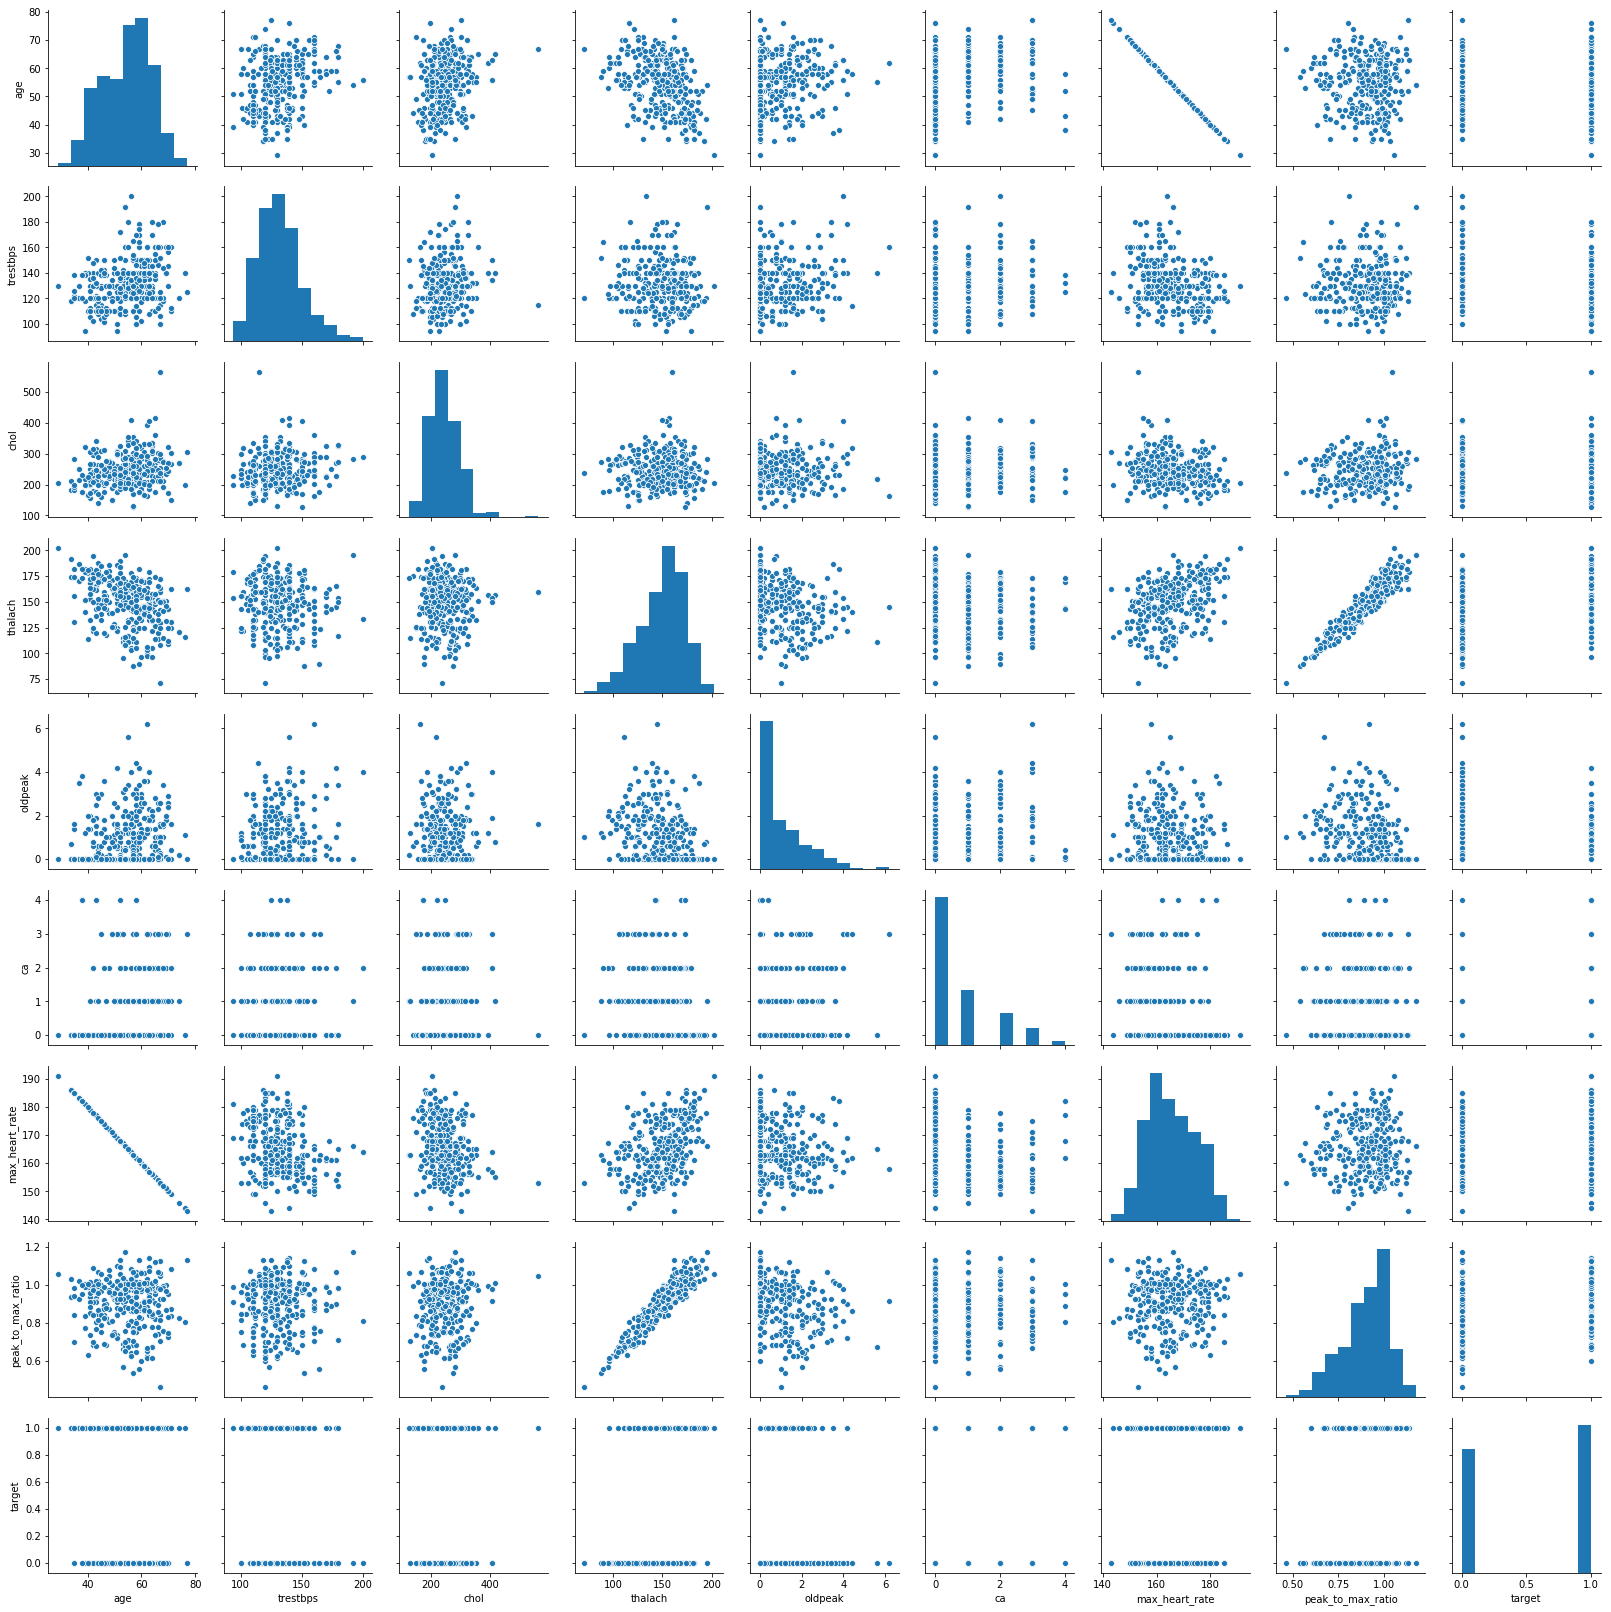

In [8]:
sns.pairplot(continuous_df)

<b>Why did we use this? </b>   
We use this to see the distributions of the independent varabiles as well as how they interact just incase we have problems with multicolinearlity.  

<b>Interesting Insights</b>  
Relationship between age and maximum heart rate.   As age increases, maximum heart rate decrease which relates back to the maximum heart rate = 220 - age.

#### Variable Differences by Target Value

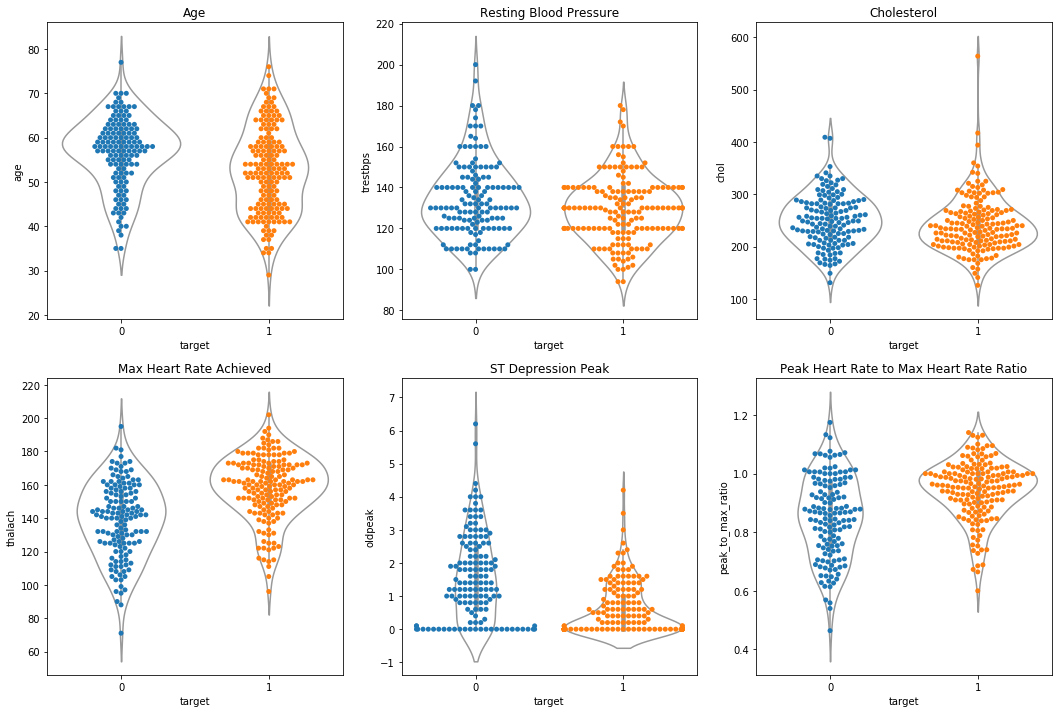

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
sns.violinplot(x="target", y="age", data=df,color = 'white',edgecolor = 'black',ax=axes[0][0]).set_title('Age')
sns.swarmplot(x="target", y="age", data=df,ax = axes[0][0])

sns.violinplot(x="target", y="trestbps", data=df,color = 'white',edgecolor = 'black',ax = axes[0][1]).set_title('Resting Blood Pressure')
sns.swarmplot(x="target", y="trestbps", data=df,ax = axes[0][1])

sns.violinplot(x="target", y="chol", data=df,color = 'white',edgecolor = 'black',ax = axes[0][2]).set_title('Cholesterol')
sns.swarmplot(x="target", y="chol", data=df,ax = axes[0][2])

sns.violinplot(x="target", y="thalach", data=df,color = 'white',edgecolor = 'black',ax = axes[1][0]).set_title('Max Heart Rate Achieved')
sns.swarmplot(x="target", y="thalach", data=df,ax = axes[1][0])

sns.violinplot(x="target", y="oldpeak", data=df,color = 'white',edgecolor = 'black',ax = axes[1][1]).set_title('ST Depression Peak')
sns.swarmplot(x="target", y="oldpeak", data=df,ax = axes[1][1])

sns.violinplot(x="target", y="peak_to_max_ratio", data=df,color = 'white',edgecolor = 'black',ax = axes[1][2]).set_title('Peak Heart Rate to Max Heart Rate Ratio')
sns.swarmplot(x="target", y="peak_to_max_ratio", data=df,ax = axes[1][2])

<b> What is this? </b>  
An overlay of a violinplot (outside lining) with a swarmplot (inside dots).

<b> Why did we do this? </b>  
To see how the distribution of each continuous variable is different in reference to the target results.  

<b> Interesting Insights </b>  
Older people seem to be in the non heart disease category. This may be because people who have heart disease don't tend to live so long.  
Max heart rate achieved has quite a different between target subsets.
Max heart rate achieved/theoretical max heart rate seems to group around 1 for people with heart disease. This shows that people with heart disease in the hospital typical hit around or above their maximum heart rate theoretically possible.

<a id="6"></a>
### Correlation matrix

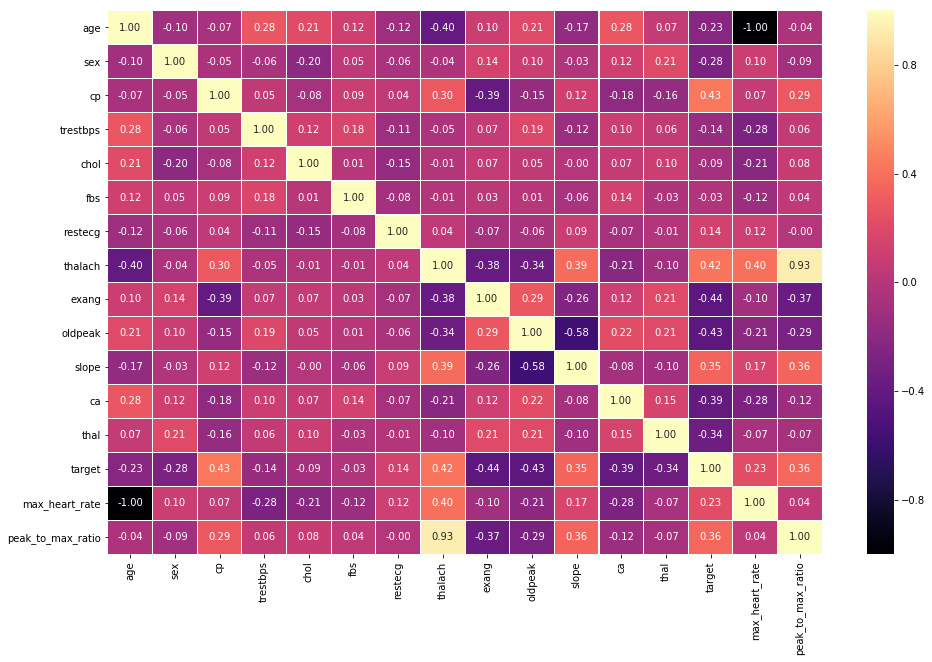

In [10]:
fig,ax = plt.subplots(figsize=(16, 10))
sns.heatmap(df.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

<b> What is this? </b>  
A correlation matrix showing the correlations between each variable (ranges from -1 to 1)

<b> Why did we do this? </b>  
To see how the variables interact with each other. Similar to the pairplot before but easier to understand the numeric correlations.

<b> Interesting Insights </b>  
The engineered features have high correlations to the features they're derived from (that's expected).  
It's about split with what features seem to have either a decent negative or positive correlation to the target.  


<hr><hr>

<a id="7"></a>
## Modeling

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

In [12]:
X = df.drop('target',axis = 1)
y = df.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2,random_state = 123)

<a id="8"></a>
### Logistic Regression

In [13]:
log = LogisticRegression()
log.fit(X_train,y_train)
print('Accuracy for Logistic Regression: %0.4f' %log.score(X_test,y_test))

Accuracy for Logistic Regression: 0.7541


<a id="9"></a>
### Simple Random Forest Classifier

In [14]:
rf = RandomForestClassifier(n_estimators = 1000,random_state = 123)
rf.fit(X_train,y_train)
rf.score(X_test,y_test)
print('Accuracy for Random Forest: %0.4f' %rf.score(X_test,y_test))

Accuracy for Random Forest: 0.7869


Random Forest beats the typical classification baseline of Logistic Regression so it proves to have some extra explanatroy power for this dataset

#### Feature Importance

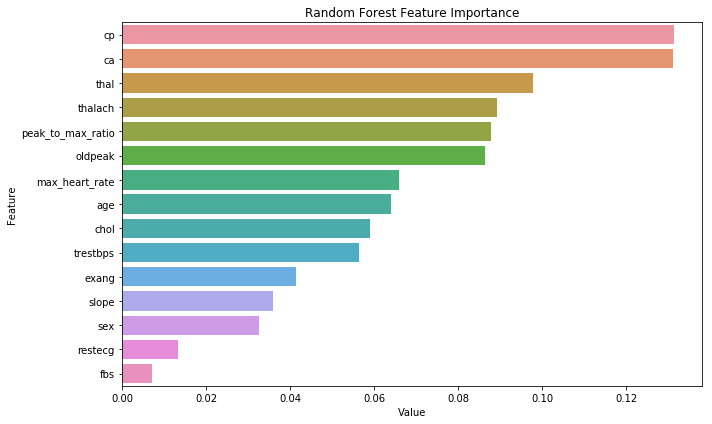

In [15]:
feature_importance = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('Random Forest Feature Importance')
plt.tight_layout()

We see that thalach and peak_to_max_ratio as well as age and max_heart_rate are very similar in importance due to their close relationship. To get a more refined more I will take age and thalach out of the dataset and see how it improves

#### Problem with Multicolinearity
Thalach and age are tightly related to peak_max_ratio and max_heart_rate to age so we'll remove thalach and age and see what happens

In [16]:
X = df.drop(['target','age','thalach'],axis = 1)
y = df.target
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .2,random_state = 123)

In [17]:
rf = RandomForestClassifier(n_estimators = 1000,random_state = 123)
rf.fit(X_train,y_train)
rf.score(X_test,y_test)
print('Accuracy for Random Forest: %0.4f' %rf.score(X_test,y_test))

Accuracy for Random Forest: 0.7705


Accuracy actually dropped, lets see how importances moved around

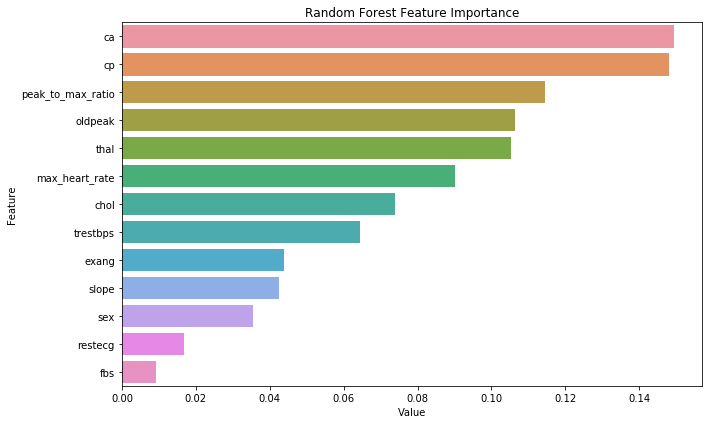

In [18]:
feature_importance = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('Random Forest Feature Importance')
plt.tight_layout()

Interesting pieces are peak_to_max_ratio and oldpeak moved up while thal shifted down a little bit. Everything else stayed the same

<a id="10"></a>
### Model Fine Tuning
Due to the dataset being so small in observations we will be doing simple train-test validation instead of cross-validation to fine tune the hyper-parameters

For this fine tuning we will not be creating a validation set and will just be using the test set to test the parameters. Because we aren't using this model against unseen data and this is purely explanatory we don't need one.

#### N Estimators
n_estimators is the number of trees within the random forest, more trees typically leads to more accruate results but takes longer to train

In [19]:
test_accuracy = []
rf = RandomForestClassifier(random_state = 123,n_jobs = -1)
forest_sizes = range(100,1001,100)
for forest_size in forest_sizes:
    rf.set_params(n_estimators = forest_size)
    rf.fit(X_train,y_train)
    test_accuracy.append(rf.score(X_test,y_test))

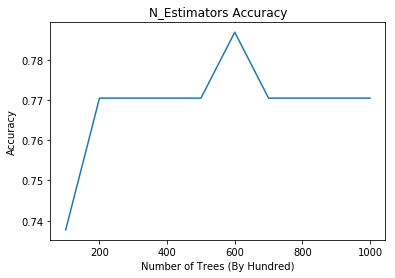

In [20]:
plt.plot(forest_sizes, test_accuracy)
plt.title('N_Estimators Accuracy')
plt.xlabel('Number of Trees (By Hundred)')
plt.ylabel('Accuracy')
plt.show()

500 Trees is the most accurate forest so we'll set it as that

#### Max Depth
max_depth tells the trees how deep they're allowed to grow, each split equals a new level so max depth restricts the amount of splits

In [21]:
test_accuracy = []
rf = RandomForestClassifier(n_estimators = 600,random_state = 123,n_jobs = -1)
depths = range(5,15)
for depth in depths:
    rf.set_params(max_depth = depth)
    rf.fit(X_train,y_train)
    test_accuracy.append(rf.score(X_test,y_test))

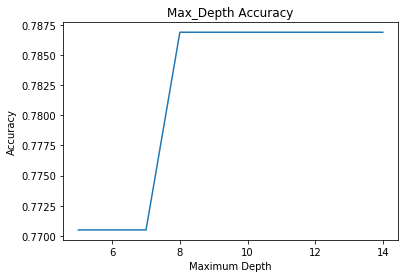

In [22]:
plt.plot(depths,test_accuracy)
plt.title('Max_Depth Accuracy')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.show()

#### Min Sample Split
min_samples_split tells the trees they can only split if both splits have this minimum amount of observations. Like max_depth this attempts to fix overfitting.

In [23]:
test_accuracy = []
rf = RandomForestClassifier(n_estimators = 600,max_depth = 10,random_state = 123,n_jobs = -1)
splits = range(2,15)
for split in splits:
    rf.set_params(min_samples_split = split)
    rf.fit(X_train,y_train)
    test_accuracy.append(rf.score(X_test,y_test))

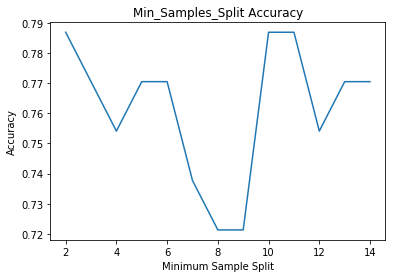

In [24]:
plt.plot(splits,test_accuracy)
plt.title('Min_Samples_Split Accuracy')
plt.xlabel('Minimum Sample Split')
plt.ylabel('Accuracy')
plt.show()

#### Max Features
max_features selects how many features are subsetted to be passed into each tree of the forest. There should be a sweet spot between creating a robust model but not under or over fitting.

In [25]:
test_accuracy = []
rf = RandomForestClassifier(n_estimators = 600,max_depth = 10,min_samples_split = 10,random_state = 123,n_jobs = -1)
features = range(2,14)
for feature in features:
    rf.set_params(max_features = feature)
    rf.fit(X_train,y_train)
    test_accuracy.append(rf.score(X_test,y_test))

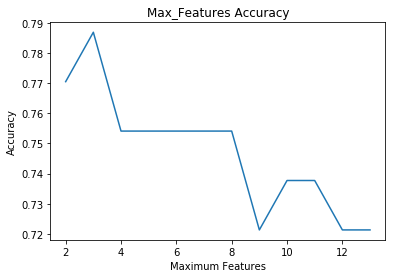

In [26]:
plt.plot(features, test_accuracy)
plt.title('Max_Features Accuracy')
plt.xlabel('Maximum Features')
plt.ylabel('Accuracy')
plt.show()

<a id="11"></a>
### Final Model

In [27]:
rf = RandomForestClassifier(n_estimators = 600,max_depth = 10,min_samples_split = 10,max_features = 3,random_state = 123,n_jobs = -1)
print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=-1,
            oob_score=False, random_state=123, verbose=0, warm_start=False)


We see the model has all the features we tuned as well as others we didnt

In [28]:
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.7868852459016393

Gained about an additional 1.5% accuracy compared to the model after we stripped away age and thalach.

#### Feature Importance

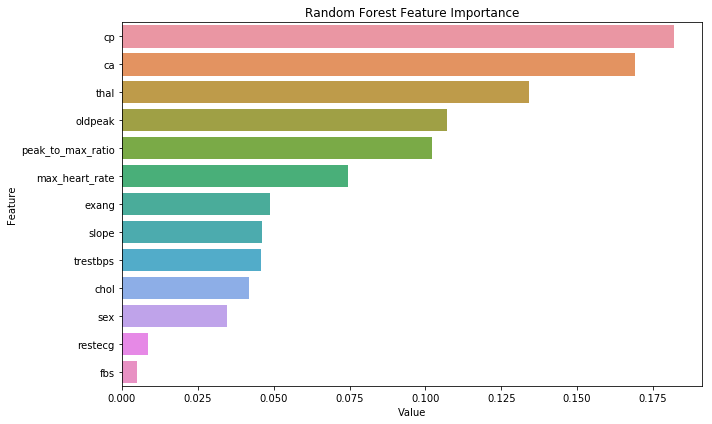

In [29]:
feature_importance = pd.DataFrame(sorted(zip(rf.feature_importances_, X.columns)), columns=['Value','Feature'])
plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False))
plt.title('Random Forest Feature Importance')
plt.tight_layout()

Finally, we see which variables are the most important. It seems the top 5 before it starts dropping off significantly are:
1. Type of chest pain (cp)
2. number of major vessels visable by xray (ca)
3. thalium stress test results (thal)
4. heartwave change relative to excercising (oldpeak) 
5. max heart rate achieved in comparison to theoretical max heart rate (peak_to_max_ratio)

<hr>

<a id="12"></a>
### Conclusion

We've seen here that the main indicators of heart disease stem from the healthiness of your heart (seems quite obvious). Although other health indicators like resting bps and blood sugar are good for overall health. Heart disease stems from having an unhealthy heart

<hr>

<a id="13"></a>
### Future Works
1. Try other machine learning models
2. More feature engineering from someone with more domain knowledge
3. Further tuning of hyper-parameters

[Back to Top](#top)